## L2 norm estimation of the equivalent layer parameters

This notebook evaluates the predicted data obtained by an equivalent layer located at depths chosen by the SED-SVD technique and others in order to compare them. Finally, the predicted data from the optimal layer is selected.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
from __future__ import division
from coord import GGS
from equiv_layer import EqLayer
from map_plot import point_map
import config_style_plot as style

style.plot_params()

In [2]:
def L1_estim(rcl, pcl, Acc_l, it_max):
    for i in range(it_max):
#         print i
        res = rcl - np.dot(Acc_l, pcl)
        W = np.dot(Acc_l.T, np.diag(1./(np.abs(res)+1e-10)) )
        pcl = np.linalg.solve(np.dot(W, Acc_l), np.dot(W, rcl))
    return pcl

### Importing observational points (planimetric only)

In [3]:
# IMPORTING BDG FILE
path = '../data/BDG/'
uf = 'MG'
name_bdg = '_file.txt'
lon, lat, alt, grav_bdg = np.loadtxt('{p}{u}{nb}'.format(p=path,u=uf,nb=name_bdg), \
skiprows=1, unpack=True)

# IMPORTING EIGEN FILE
name_eigen = '.dat'
grav_eigen = np.loadtxt('{p}{u}{ne}'.format(p=path,u=uf,ne=name_eigen),skiprows=32, usecols=(4,),unpack=True)

# Obtaining short wavelength signals
disturb = grav_bdg - grav_eigen
print disturb[0], disturb.size, lon.size, lat.size, alt.size#, h_eigen.size

-0.637237599934 4796 4796 4796 4796


In [4]:
tobedel = np.where(np.abs(disturb)>110.)[0]
print tobedel.size, tobedel, disturb[tobedel], alt[tobedel]

5 [2600 3027 3211 3212 3213] [-164.8829593 -123.4023368 -144.0662624 -114.1573071  163.2417691] [  848.46   499.1    849.22  1236.6   1524.96]


In [5]:
disturb = np.delete(disturb, tobedel)
lon = np.delete(lon, tobedel)
lat = np.delete(lat, tobedel)
alt = np.delete(alt, tobedel)
print disturb.size, lon.size, lat.size, alt.size

4791 4791 4791 4791


In [6]:
# CHANGE ALTITUDE UNITS ON MAP
# point_map(lon, lat, alt, alt, uf, edges=(-53.,-39.8,-23.1,-13.8), center=(-21.,-16.,-45.), drawlines=(2.,1.), sign=(-52.2,-52.34,-15.5,-17.8), cmap='terrain', fig_size=(8.,9.))

In [7]:
# point_map(lon, lat, alt, disturb, uf, edges=(-53.,-39.8,-23.1,-13.8), center=(-21.,-16.,-45.), drawlines=(2.,1.), sign=(-52.2,-52.34,-15.5,-17.8), lim_val=(True,60.), fig_size=(8.,9.))

### Calculating rotation matrices and Cartesian coordinates

In [8]:
# Calculating Cartesian coordinates
x, y, z = GGS().geodetic2cartesian(lon, lat, alt)
R = np.array(GGS().rotation_matrix(lon, lat))

## Estimativa das camadas locais

In [9]:
pc = []
hc = []
indc = []
xc = []
yc = []
zc = []
Rc = []
rabs_max = []
taur = 1e-11 #1e-5 #0.05
tauc = 1e-3
it_max_l1 = 5

In [10]:
latc = []
lonc = []

## Iteração 1 - A0

In [11]:
indl = np.arange(disturb.size)
mi_c = 1e-10
hcl = 5000. #14200. # 20000. #800. #1000.
print hcl, type(indl), #indl

5000.0 <type 'numpy.ndarray'>


In [12]:
rcl = disturb[indl]
xcl = x[indl]
ycl = y[indl]
zcl = z[indl]

latcl = lat[indl]
loncl = lon[indl]

In [13]:
Rcl = R[:, indl]

In [14]:
# Calculo de Acc_l
hlay = np.zeros(indl.size) - hcl
xlay, ylay, zlay = GGS().geodetic2cartesian(hlay, latcl, loncl)
Lay = EqLayer(lon, lat, np.zeros_like(lon)-hcl)
layer = Lay.build_layer(xlay, ylay, zlay)
Acc_l = Lay.designMat(xcl, ycl, zcl, Rcl, layer)
print Acc_l.shape

(4791, 4791)


In [15]:
H = np.dot(Acc_l.T, Acc_l)
# H += mi_c*np.trace(H)*np.identity(indl.size)
H += (mi_c*np.trace(H)*np.identity(indl.size))/indl.size

In [16]:
p_L2 = np.linalg.solve(H, np.dot(Acc_l.T, rcl))
print p_L2.size
# p_L1 = L1_estim(rcl, p_L2, Acc_l, 3)

4791


In [17]:
rcl -= np.dot(Acc_l, p_L2)
print rcl[:50]

[ -1.44800061  -4.87355692  -7.63816155  -3.45517774   3.69086574
  -4.07293415  -3.87256657  -3.48162498  -6.20913936  -4.22075251
  -1.96264954  -2.64223381  -1.35144177  -5.53358857  -5.09710156
  -2.71167377  -1.09157524  -2.75782923  -2.4009791   -4.13125     -3.56798833
 -53.56046446  -2.14841754  -4.26545627  -1.5008244    2.85950629
  -3.50244911  -8.01517961  -2.87266735  -6.33753047   7.0576265
  20.17221778   6.63225853  20.77287938  -2.70441218  -4.1309801
  -2.75602337  -5.33737637  -3.02748346  -2.05031117  -5.80531314
  -2.47457759   0.55642357  -0.45947584  -1.37981238  -3.03696675
  -1.97864796   2.1861066    8.56923764   1.03032007]


In [18]:
indexing = np.where(rcl==np.max(rcl))[0]
index = np.where(disturb==np.max(disturb))[0]
print 'MAX FOR RESIDUALS'
print rcl[indexing], disturb[indexing], np.dot(Acc_l, p_L2)[indexing]
print 'MAX FOR DISTURB'
print rcl[index], disturb[index], np.dot(Acc_l, p_L2)[index]

MAX FOR RESIDUALS
[ 104.91206091] [ 105.6582854] [ 0.74622449]
MAX FOR DISTURB
[ 104.91206091] [ 105.6582854] [ 0.74622449]


In [19]:
print np.std(rcl)

10.7219361559


In [20]:
rabs_max_l = np.max(np.abs(rcl))
rabs_max_l

104.912060906889

In [21]:
print rabs_max, rabs_max_l

[] 104.912060907


In [22]:
pc.append(p_L2)
hc.append(hcl)
indc.append(indl)
xc.append(xcl)
yc.append(ycl)
zc.append(zcl)
Rc.append(Rcl)

In [23]:
latc.append(latcl)
lonc.append(loncl)

In [24]:
rabs_max.append(rabs_max_l)

In [25]:
rc = rcl[:] #r1

In [26]:
print np.max(np.abs(rc))

104.912060907


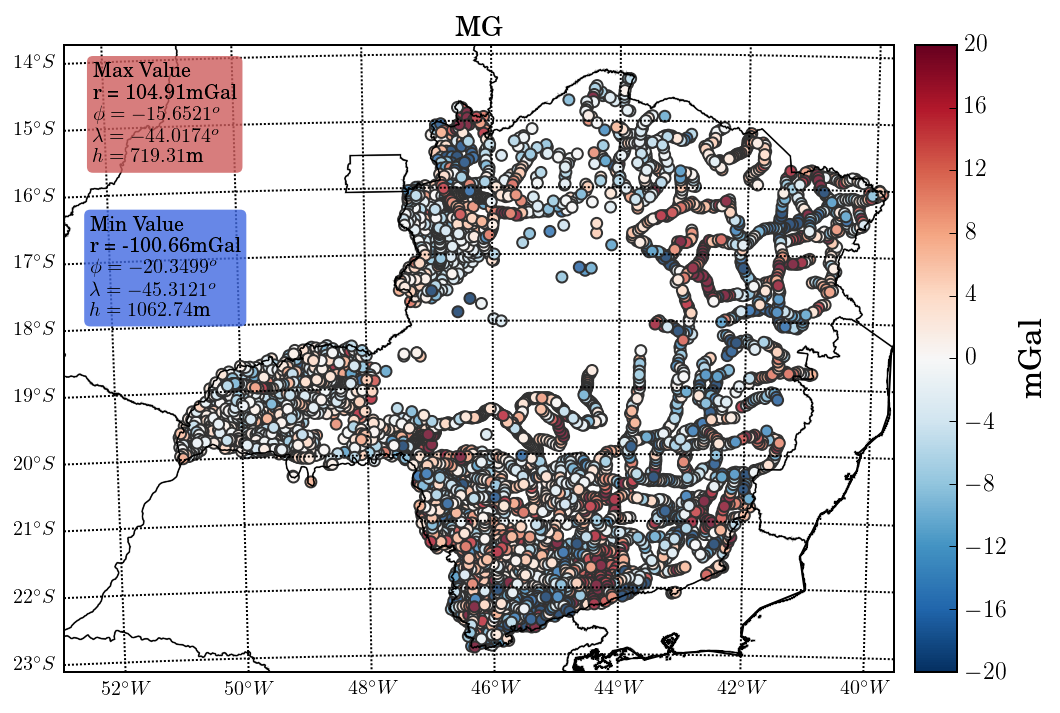

In [27]:
# Residual
point_map(lon, lat, alt, rc, uf, edges=(-53.,-39.8,-23.1,-13.8), center=(-21.,-16.,-45.), drawlines=(2.,1.), sign=(-52.2,-52.34,-15.5,-17.8), residual=True, lim_val=(True,20.), fig_size=(8.,9.))

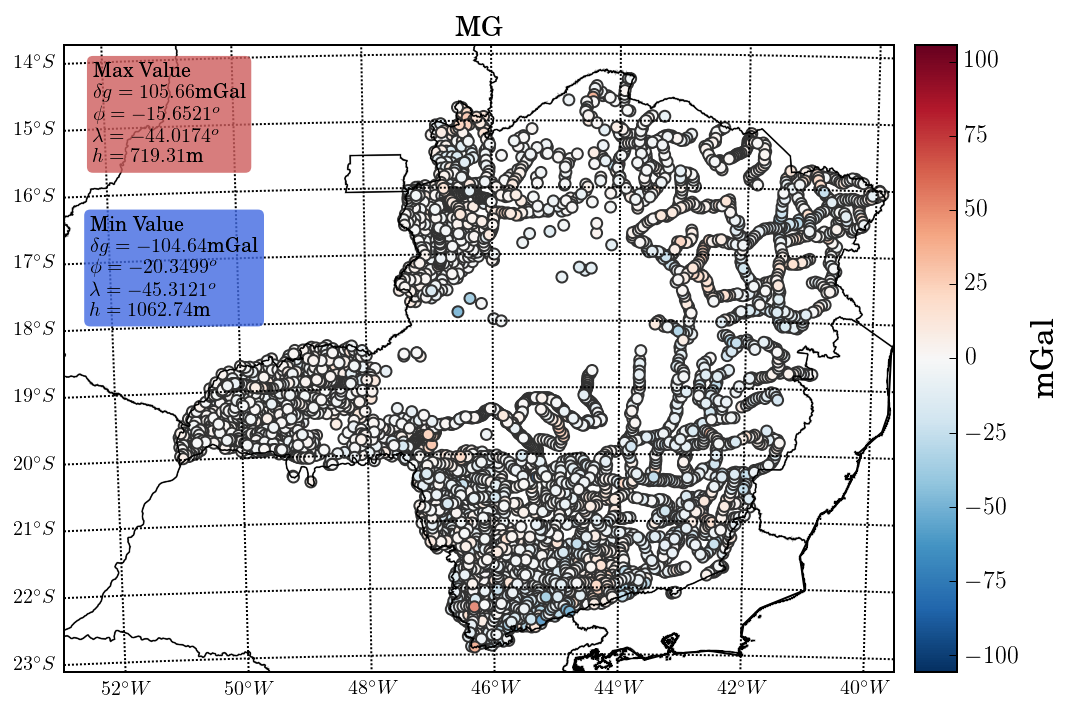

In [28]:
# Observed data
point_map(lon, lat, alt, disturb, uf, edges=(-53.,-39.8,-23.1,-13.8), center=(-21.,-16.,-45.), drawlines=(2.,1.), sign=(-52.2,-52.34,-15.5,-17.8), lim_val=(False,), fig_size=(8.,9.))

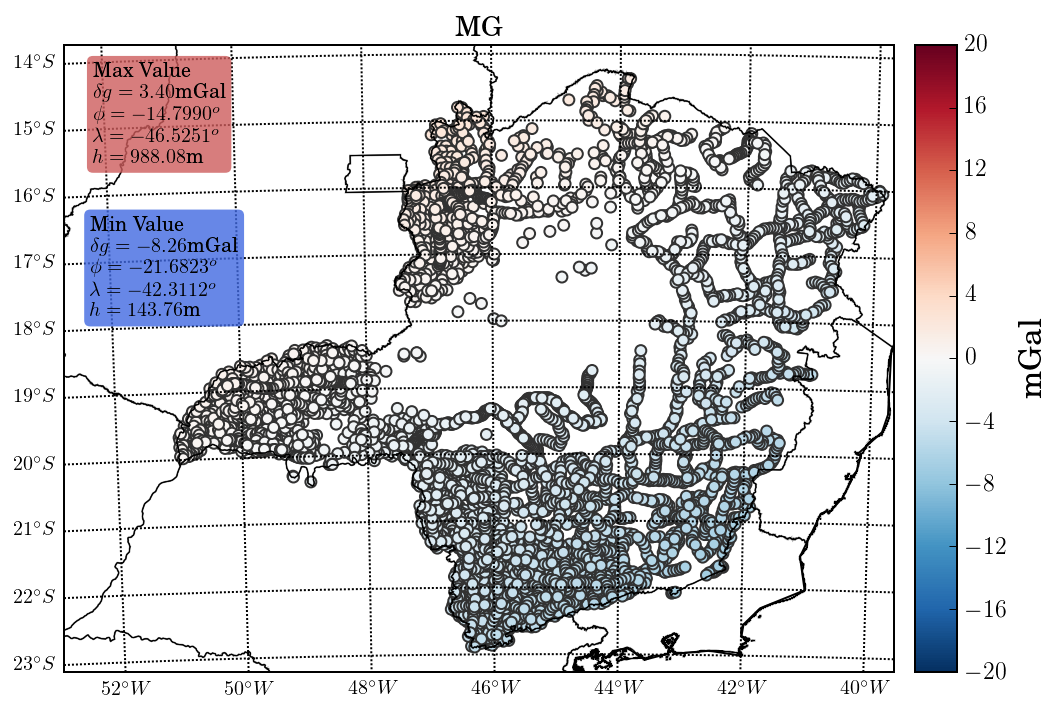

In [29]:
# Predicted data
point_map(lon, lat, alt, np.dot(Acc_l, p_L2), uf, edges=(-53.,-39.8,-23.1,-13.8), center=(-21.,-16.,-45.), drawlines=(2.,1.), sign=(-52.2,-52.34,-15.5,-17.8), lim_val=(True,20.), fig_size=(8.,9.))

In [30]:
ind_ = np.where(np.abs(rc) >= 1.)[0]
print ind_.size, p_L2.size

4302 4791


#### Second layer

In [ ]:
indl = np.copy(ind_)
hcl = 5000 #14200. # 20000. #800. #1000.
print hcl, type(indl), #indl

In [ ]:
data = rc[indl]
rcl = np.copy(data)
print np.max(rcl)
xcl = x[indl]
ycl = y[indl]
zcl = z[indl]

latcl = lat[indl]
loncl = lon[indl]

In [ ]:
Rcl = R[:, ind_]

In [ ]:
# Calculo de Acc_l
hlay = np.zeros(indl.size) - hcl
xlay, ylay, zlay = GGS().geodetic2cartesian(hlay, latcl, loncl)
Lay = EqLayer(lon, lat, np.zeros_like(lon)-hcl)
layer = Lay.build_layer(xlay, ylay, zlay)
Acc_l = Lay.designMat(xcl, ycl, zcl, Rcl, layer)
print Acc_l.shape

In [ ]:
H = np.dot(Acc_l.T, Acc_l)
# H += mi_c*np.trace(H)*np.identity(indl.size)
H += (mi_c*np.trace(H)*np.identity(indl.size))/indl.size

In [ ]:
p_L2 = np.linalg.solve(H, np.dot(Acc_l.T, rcl))
print p_L2.size

In [ ]:
rcl -= np.dot(Acc_l, p_L2)

In [ ]:
indexing = np.where(rcl==np.max(rcl))[0]
print 'MAX FOR RESIDUALS'
print rcl[indexing], data[indexing], np.dot(Acc_l, p_L2)[indexing]

In [ ]:
print np.std(rcl)

In [ ]:
rabs_max_l = np.max(np.abs(rcl))
rabs_max_l

In [ ]:
print rabs_max, rabs_max_l

In [ ]:
pc.append(p_L2)
hc.append(hcl)
indc.append(indl)
xc.append(xcl)
yc.append(ycl)
zc.append(zcl)
Rc.append(Rcl)

In [ ]:
latc.append(latcl)
lonc.append(loncl)

In [ ]:
rabs_max.append(rabs_max_l)

In [ ]:
# rc = rcl[:] #r1
rc[indl] = rcl #r1

In [ ]:
print np.max(np.abs(rc))

In [ ]:
# Residual
point_map(lon, lat, alt, rc, uf, edges=(-53.,-39.8,-23.1,-13.8), center=(-21.,-16.,-45.), drawlines=(2.,1.), sign=(-52.2,-52.34,-15.5,-17.8), residual=True, lim_val=(True,60.), fig_size=(8.,9.))

In [ ]:
# Observed data
point_map(lon, lat, alt, disturb, uf, edges=(-53.,-39.8,-23.1,-13.8), center=(-21.,-16.,-45.), drawlines=(2.,1.), sign=(-52.2,-52.34,-15.5,-17.8), lim_val=(False,), fig_size=(8.,9.))

In [ ]:
# Predicted data
point_map(lon, lat, alt, np.dot(Acc_l, p_L2), uf, edges=(-53.,-39.8,-23.1,-13.8), center=(-21.,-16.,-45.), drawlines=(2.,1.), sign=(-52.2,-52.34,-15.5,-17.8), lim_val=(False,), fig_size=(8.,9.))

In [ ]:
ind_ = np.where(np.abs(rc) >= 1e-5)[0]
print ind_.size, p_L2.size

In [ ]:
rc[ind_]

#### Third layer

In [ ]:
indl = ind_
hcl = 700. #14200. # 20000. #800. #1000.
print hcl, type(indl), #indl

In [ ]:
data = rc[indl]
rcl = np.copy(data)
xcl = x[indl]
ycl = y[indl]
zcl = z[indl]

latcl = lat[indl]
loncl = lon[indl]

In [ ]:
Rcl = R[:, indl]

In [ ]:
# Calculo de Acc_l
hlay = np.zeros(indl.size) - hcl
xlay, ylay, zlay = coord.geodetic2cartesian(hlay, latcl, loncl, a, b)
lay = eqlayer.build_layer(xlay, ylay, zlay)
Acc_l = eqlayer.designMat(xcl, ycl, zcl, Rcl, lay)

In [ ]:
H = np.dot(Acc_l.T, Acc_l)
# H += mi_c*np.trace(H)*np.identity(indl.size)
H += (mi_c*np.trace(H)*np.identity(indl.size))/indl.size

In [ ]:
p_L2 = np.linalg.solve(H, np.dot(Acc_l.T, rcl))
print p_L2.size

In [ ]:
rcl -= np.dot(Acc_l, p_L2)

In [ ]:
indexing = np.where(rcl==np.max(rcl))[0]
print 'MAX FOR RESIDUALS'
print rcl[indexing], data[indexing], np.dot(Acc_l, p_L2)[indexing]

In [ ]:
print np.std(rcl)

In [ ]:
rabs_max_l = np.max(np.abs(rcl))
rabs_max_l

In [ ]:
print rabs_max, rabs_max_l

In [ ]:
pc.append(p_L2)
hc.append(hcl)
indc.append(indl)
xc.append(xcl)
yc.append(ycl)
zc.append(zcl)
Rc.append(Rcl)

In [ ]:
latc.append(latcl)
lonc.append(loncl)

In [ ]:
rabs_max.append(rabs_max_l)

In [ ]:
# rc = rcl[:] #r1
rc[indl] = rcl #r1

In [ ]:
print np.max(np.abs(rc))

In [ ]:
# Residual
mp.plot_map(lon[indl], lat[indl], alt[indl], rcl, uf, config='stations', \
            edges=(-55.,-44.,-25.5,-19.), center=(-23.5,-21,-48.5), drawlines=(2.,1.), \
            sign=(-54.6,-54.65,-20.9,-24.6), residual=True, lim_val=(False,), \
            fig_size=(8.,9.))#, save=name), save=name)

In [ ]:
# Observed data
mp.plot_map(lon[indl], lat[indl], alt[indl], data, uf, config='stations', \
            edges=(-55.,-44.,-25.5,-19.), center=(-23.5,-21,-48.5), drawlines=(2.,1.), \
            sign=(-54.6,-54.65,-20.9,-24.6), lim_val=(False,), fig_size=(8.,9.))#, save=name), save=name)

In [ ]:
# Predicted data
mp.plot_map(lon[indl], lat[indl], alt[indl], np.dot(Acc_l, p_L2), uf, config='stations', \
            edges=(-55.,-44.,-25.5,-19.), center=(-23.5,-21,-48.5), drawlines=(2.,1.), \
            sign=(-54.6,-54.65,-20.9,-24.6), lim_val=(False,), fig_size=(8.,9.))#, save=name), save=name)

In [ ]:
ind_ = np.where(np.abs(rc) >= 1e-5)[0]
print ind_.size, p_L2.size

In [ ]:
lat_multi = np.concatenate(latc)
lon_multi = np.concatenate(lonc)

height_multi = []
for lonci, hci, in zip(lonc, hc):
    height_multi.append(np.zeros_like(lonci) - hci)
height_multi = np.concatenate(height_multi)

In [ ]:
x_multi, y_multi, z_multi = coord.geodetic2cartesian(height_multi, lat_multi, lon_multi, a, b)
lay = eqlayer.build_layer(x_multi, y_multi, z_multi)

In [ ]:
p_multi = np.concatenate(pc)
print len(p_multi), p_multi

### Loading BR FULL GRID

In [ ]:
# Loading files
deg = '08'
h = 3
path = '../data/dados/EIGEN/WGS84/EIGEN_BR_{}deg_{}km_full.gdf'.format(deg,str(h))
BR_total = np.loadtxt(path,skiprows=34,unpack=True)
BR_total[0] = BR_total[0]-360.
dist_BR = BR_total[2]-ng.gamma_closedform(np.zeros_like(BR_total[0])+3000., BR_total[1])
# print BR_total[:5]

In [ ]:
print 'lon_min=', np.min(lon), 'lon_max=', np.max(lon)
print 'lat_min=', np.min(lat), 'lat_max=', np.max(lat)

In [ ]:
lon_sorted, lon_indices, lon_inverse = np.unique(BR_total[0], return_index=True, return_inverse=True)
lat_sorted, lat_indices, lat_inverse = np.unique(BR_total[1], return_index=True, return_inverse=True)
# print lon_sorted.size, lon_indices, lon_inverse.size, lon_inverse
# print lat_sorted.size#, lat_sorted

In [ ]:
index_lon_min = (np.abs(lon_sorted+0.96-np.min(lon))).argmin()
index_lon_max = (np.abs(lon_sorted-0.96-np.max(lon))).argmin()
print index_lon_min, lon_sorted[index_lon_min], np.min(lon)
print index_lon_max, lon_sorted[index_lon_max], np.max(lon)

In [ ]:
index_lat_min = (np.abs(lat_sorted+0.96-np.min(lat))).argmin()
index_lat_max = (np.abs(lat_sorted-0.96-np.max(lat))).argmin()
print index_lat_min, lat_sorted[index_lat_min], np.min(lat)
print index_lat_max, lat_sorted[index_lat_max], np.max(lat)

In [ ]:
lon_mask, lat_mask = np.meshgrid(lon_sorted[index_lon_min:index_lon_max+1],\
                                 lat_sorted[index_lat_min:index_lat_max+1])
lon_mask = np.ravel(lon_mask)
lat_mask = np.ravel(lat_mask)
print lat_mask.size, lon_mask.size

In [ ]:
#1grau - 111km
#0.2 - x
print 0.24*111
0.08*12

In [ ]:
# Obs
x, y, z = coord.geodetic2cartesian(np.zeros_like(lon_mask)+3000., lat_mask, lon_mask, a, b)
R_br = coord.rotation_matrix(lat_mask, lon_mask)

# PM
A = eqlayer.designMat(x, y, z, R_br, lay)
print A.shape

### Calculating predicted field over zone 6 observation points

In [ ]:
# pred_SP = np.dot(A, p_L2)
pred_SP = np.dot(A, np.asarray(p_multi))
print pred_SP.size, np.max(pred_SP), np.min(pred_SP)

In [ ]:
# Observed data
mp.plot_map(lon, lat, alt, disturb, uf, config='stations', edges=(-55.,-44.,-25.5,-19.), \
            center=(-23.5,-21,-48.5), drawlines=(2.,1.), sign=(-54.6,-54.65,-20.9,-24.6), \
            lim_val=(False,), fig_size=(8.,9.))#, save=name)
# Predicted data
mp.plot_map(lon_mask, lat_mask, np.zeros_like(lat_mask)+3000., pred_SP, uf, config='grid', \
            edges=(-55.,-44.,-25.5,-19.), center=(-23.5,-21,-48.5), drawlines=(2.,1.), \
            sign=(-54.6,-54.65,-20.9,-24.6), lim_val=(True,60), fig_size=(8.,9.))#, save=name)

### L1 estimation

In [ ]:
rcl = disturb[indl]
xcl = x[indl]
ycl = y[indl]
zcl = z[indl]

latcl = lat[indl]
loncl = lon[indl]

In [ ]:
Rcl = R[:, indl]

In [ ]:
# Calculo de Acc_l
hlay = np.zeros(indl.size) - hcl
xlay, ylay, zlay = coord.geodetic2cartesian(hlay, latcl, loncl, a, b)
lay = eqlayer.build_layer(xlay, ylay, zlay)
Acc_l = eqlayer.designMat(xcl, ycl, zcl, Rcl, lay)

In [ ]:
H = np.dot(Acc_l.T, Acc_l)
# H += mi_c*np.trace(H)*np.identity(indl.size)
H += (mi_c*np.trace(H)*np.identity(indl.size))/indl.size

In [ ]:
p_L2 = np.linalg.solve(H, np.dot(Acc_l.T, rcl))
print p_L2.size

In [ ]:
p_L1 = L1_estim(rcl, p_L2, Acc_l, 3)
print p_L1.size

In [ ]:
# # save.save_pickle(p_L1, nb_name, '../data/L1_parameters/pL1_BDG-{}_2km-depth.pickle'.format(uf))
# fname = '../data/L1_parameters/p{}_BDG-{}_{}km-depth.pickle'.format('L2',uf,hcl/1000.)
# save.param2pickle(lon, lat, hlay, p_L2, category=('geod_coord','phys_prop'), \
#                   nb_name=nb_name, path=fname)

In [ ]:
rcl -= np.dot(Acc_l, p_L1)

In [ ]:
indexing = np.where(rcl==np.max(rcl))[0]
index = np.where(disturb==np.max(disturb))[0]
print 'MAX FOR RESIDUALS'
print rcl[indexing], disturb[indexing], np.dot(Acc_l, p_L2)[indexing]
print 'MAX FOR DISTURB'
print rcl[index], disturb[index], np.dot(Acc_l, p_L2)[index]

In [ ]:
print np.std(rcl)

In [ ]:
rabs_max_l = np.max(np.abs(rcl))
rabs_max_l

In [ ]:
print rabs_max, rabs_max_l

In [ ]:
pc.append(p_L1)
hc.append(hcl)
indc.append(indl)
xc.append(xcl)
yc.append(ycl)
zc.append(zcl)
Rc.append(Rcl)

In [ ]:
latc.append(latcl)
lonc.append(loncl)

In [ ]:
rabs_max.append(rabs_max_l)

In [ ]:
rc = rcl[:] #r1

In [ ]:
print np.max(np.abs(rc))

In [ ]:
# Residual
mp.plot_map(lon, lat, alt, rc, uf, config='stations', edges=(-55.,-44.,-25.5,-19.), \
            center=(-23.5,-21,-48.5), drawlines=(2.,1.), sign=(-54.6,-54.65,-20.9,-24.6), \
            residual=True, lim_val=(False,), fig_size=(8.,9.))#, save=name), save=name)

In [ ]:
# Observed data
mp.plot_map(lon, lat, alt, disturb, uf, config='stations', edges=(-55.,-44.,-25.5,-19.), \
            center=(-23.5,-21,-48.5), drawlines=(2.,1.), sign=(-54.6,-54.65,-20.9,-24.6), \
            lim_val=(False,), fig_size=(8.,9.))#, save=name), save=name)

In [ ]:
# Predicted data
mp.plot_map(lon, lat, alt, np.dot(Acc_l, p_L1), uf, config='stations', edges=(-55.,-44.,-25.5,-19.), \
            center=(-23.5,-21,-48.5), drawlines=(2.,1.), sign=(-54.6,-54.65,-20.9,-24.6), \
            lim_val=(False,), fig_size=(8.,9.))#, save=name), save=name)

In [ ]:
ind_ = np.where(np.abs(rc) >= 1e-5)[0]
print ind_.size, p_L2.size

### Calculating predicted field over zone 6 observation points

In [ ]:
pred_SP = np.dot(A, p_L1)
print pred_SP.size, np.max(pred_SP), np.min(pred_SP)

In [ ]:
# Observed data
mp.plot_map(lon, lat, alt, disturb, uf, config='stations', edges=(-55.,-44.,-25.5,-19.), \
            center=(-23.5,-21,-48.5), drawlines=(2.,1.), sign=(-54.6,-54.65,-20.9,-24.6), \
            lim_val=(False,), fig_size=(8.,9.))#, save=name)
# Predicted data
mp.plot_map(lon_mask, lat_mask, np.zeros_like(lat_mask)+3000., pred_SP, uf, config='grid', \
            edges=(-55.,-44.,-25.5,-19.), center=(-23.5,-21,-48.5), drawlines=(2.,1.), \
            sign=(-54.6,-54.65,-20.9,-24.6), lim_val=(False,), fig_size=(8.,9.))#, save=name)

## Iteração 1 - B

In [ ]:
indl = np.arange(disturb.size)
hcl = 5000. # 20000. #15000. #800. #1000.
print hcl

In [ ]:
rcl = rc[indl]
xcl = x[indl]
ycl = y[indl]
zcl = z[indl]

latcl = lat[indl]
loncl = lon[indl]

In [ ]:
Rcl = R[:, indl]

In [ ]:
# Calculo de Acc_l
hlay = np.zeros(indl.size) - hcl
xlay, ylay, zlay = coord.geodetic2cartesian(hlay, latcl, loncl, a, b)
lay = eqlayer.build_layer(xlay, ylay, zlay)
Acc_l = eqlayer.designMat(xcl, ycl, zcl, Rcl, lay)

In [ ]:
H = np.dot(Acc_l.T, Acc_l)
# H += mi_c*np.trace(H)*np.identity(indl.size)
H += (mi_c*np.trace(H)*np.identity(indl.size))/indl.size

In [ ]:
p_L2 = np.linalg.solve(H, np.dot(Acc_l.T, rcl))
print p_L2.size

In [ ]:
# p_L1 = eqlayer.L1_norm_estim(rcl, p_L2, Acc_l, it_max_l1) #3
# p_L1 = L1_estim(rcl, p_L2, Acc_l, it_max_l1) #3
# print p_L1.size

In [ ]:
rcl -= np.dot(Acc_l, p_L2)

In [ ]:
indexing = np.where(rcl==np.max(rcl))[0]
index = np.where(disturb==np.max(disturb))[0]
print 'MAX FOR RESIDUALS'
print rcl[indexing], disturb[indexing], np.dot(Acc_l, p_L2)[indexing]
print 'MAX FOR DISTURB'
print rcl[index], disturb[index], np.dot(Acc_l, p_L2)[index]

In [ ]:
-0.00024871 + 1.01344449

In [ ]:
print np.std(rcl)

In [ ]:
rabs_max_l = np.max(np.abs(rcl))
rabs_max_l

In [ ]:
print rabs_max, rabs_max_l

In [ ]:
pc.append(p_L2)
hc.append(hcl)
indc.append(indl)
xc.append(xcl)
yc.append(ycl)
zc.append(zcl)
Rc.append(Rcl)

In [ ]:
latc.append(latcl)
lonc.append(loncl)

In [ ]:
rabs_max.append(rabs_max_l)

In [ ]:
rc_n = rcl[:] #r1

In [ ]:
print np.max(np.abs(rc))

In [ ]:
# Residual
mp.plot_map(lon, lat, alt, rc_n, uf, config='stations', edges=(-55.,-44.,-25.5,-19.), \
            center=(-23.5,-21,-48.5), drawlines=(2.,1.), sign=(-54.6,-54.65,-20.9,-24.6), \
            residual=True, lim_val=(False,), fig_size=(8.,9.))#, save=name), save=name)

In [ ]:
# Observed data
mp.plot_map(lon, lat, alt, disturb, uf, config='stations', edges=(-55.,-44.,-25.5,-19.), \
            center=(-23.5,-21,-48.5), drawlines=(2.,1.), sign=(-54.6,-54.65,-20.9,-24.6), \
            lim_val=(False,), fig_size=(8.,9.))#, save=name), save=name)

In [ ]:
# Predicted data
mp.plot_map(lon, lat, alt, np.dot(Acc_l, p_L2), uf, config='stations', edges=(-55.,-44.,-25.5,-19.), \
            center=(-23.5,-21,-48.5), drawlines=(2.,1.), sign=(-54.6,-54.65,-20.9,-24.6), \
            lim_val=(False,), fig_size=(8.,9.))#, save=name), save=name)

In [ ]:
ind_ = np.where(np.abs(rc) >= 1e-5)[0]
print ind_.size
print np.mean(rc[ind_])

In [ ]:
# rc[ind_]

### Calculating predicted field over zone 6 observation points

In [ ]:
pred_SP = np.dot(A, p_L2)
print pred_SP.size, np.max(pred_SP), np.min(pred_SP)

In [ ]:
# Observed data
mp.plot_map(lon, lat, alt, disturb, uf, config='stations', edges=(-55.,-44.,-25.5,-19.), \
            center=(-23.5,-21,-48.5), drawlines=(2.,1.), sign=(-54.6,-54.65,-20.9,-24.6), \
            lim_val=(False,), fig_size=(8.,9.))#, save=name)
# Predicted data
mp.plot_map(lon_mask, lat_mask, np.zeros_like(lat_mask)+3000., pred_SP, uf, config='grid', \
            edges=(-55.,-44.,-25.5,-19.), center=(-23.5,-21,-48.5), drawlines=(2.,1.), \
            sign=(-54.6,-54.65,-20.9,-24.6), lim_val=(False,), fig_size=(8.,9.))#, save=name)

## Iteração 1 - C

In [ ]:
indl = np.arange(disturb.size)
hcl = 4500. # 20000. #15000. #800. #1000.
print hcl

In [ ]:
rcl = disturb[indl]
xcl = x[indl]
ycl = y[indl]
zcl = z[indl]

latcl = lat[indl]
loncl = lon[indl]

In [ ]:
Rcl = R[:, indl]

In [ ]:
# Calculo de Acc_l
hlay = np.zeros(indl.size) - hcl
xlay, ylay, zlay = coord.geodetic2cartesian(hlay, latcl, loncl, a, b)
lay = eqlayer.build_layer(xlay, ylay, zlay)
Acc_l = eqlayer.designMat(xcl, ycl, zcl, Rcl, lay)

In [ ]:
H = np.dot(Acc_l.T, Acc_l)
# H += mi_c*np.trace(H)*np.identity(indl.size)
H += (mi_c*np.trace(H)*np.identity(indl.size))/indl.size

In [ ]:
p_L2 = np.linalg.solve(H, np.dot(Acc_l.T, rcl))
print p_L2.size

In [ ]:
# p_L1 = eqlayer.L1_norm_estim(rcl, p_L2, Acc_l, it_max_l1) #3
# p_L1 = L1_estim(rcl, p_L2, Acc_l, it_max_l1) #3
# print p_L1.size

In [ ]:
rcl -= np.dot(Acc_l, p_L2)

In [ ]:
indexing = np.where(rcl==np.max(rcl))[0]
index = np.where(disturb==np.max(disturb))[0]
print 'MAX FOR RESIDUALS'
print rcl[indexing], disturb[indexing], np.dot(Acc_l, p_L2)[indexing]
print 'MAX FOR DISTURB'
print rcl[index], disturb[index], np.dot(Acc_l, p_L2)[index]

In [ ]:
-2.1174715+62.7661986

In [ ]:
print np.std(rcl)

In [ ]:
rabs_max_l = np.max(np.abs(rcl))
rabs_max_l

In [ ]:
print rabs_max, rabs_max_l

In [ ]:
pc.append(p_L2)
hc.append(hcl)
indc.append(indl)
xc.append(xcl)
yc.append(ycl)
zc.append(zcl)
Rc.append(Rcl)

In [ ]:
latc.append(latcl)
lonc.append(loncl)

In [ ]:
rabs_max.append(rabs_max_l)

In [ ]:
rc = rcl[:] #r1

In [ ]:
print np.max(np.abs(rc))

In [ ]:
# Residual
mp.plot_map(lon, lat, alt, rc, uf, config='stations', edges=(-55.,-44.,-25.5,-19.), \
            center=(-23.5,-21,-48.5), drawlines=(2.,1.), sign=(-54.6,-54.65,-20.9,-24.6), \
            residual=True, lim_val=(False,), fig_size=(8.,9.))#, save=name), save=name)

In [ ]:
# Observed data
mp.plot_map(lon, lat, alt, disturb, uf, config='stations', edges=(-55.,-44.,-25.5,-19.), \
            center=(-23.5,-21,-48.5), drawlines=(2.,1.), sign=(-54.6,-54.65,-20.9,-24.6), \
            lim_val=(False,), fig_size=(8.,9.))#, save=name), save=name)

In [ ]:
# Predicted data
mp.plot_map(lon, lat, alt, np.dot(Acc_l, p_L2), uf, config='stations', edges=(-55.,-44.,-25.5,-19.), \
            center=(-23.5,-21,-48.5), drawlines=(2.,1.), sign=(-54.6,-54.65,-20.9,-24.6), \
            lim_val=(False,), fig_size=(8.,9.))#, save=name)

In [ ]:
ind_ = np.where(np.abs(rc) >= 1e-5)[0]
print ind_.size
print np.mean(rc[ind_])

In [ ]:
# rc[ind_]

### Calculating predicted field over zone 6 observation points

In [ ]:
pred_SP = np.dot(A, p_L2)
print pred_SP.size, np.max(pred_SP), np.min(pred_SP)

In [ ]:
# Observed data
mp.plot_map(lon, lat, alt, disturb, uf, config='stations', edges=(-55.,-44.,-25.5,-19.), \
            center=(-23.5,-21,-48.5), drawlines=(2.,1.), sign=(-54.6,-54.65,-20.9,-24.6), \
            lim_val=(False,), fig_size=(8.,9.))#, save=name)
# Predicted data
mp.plot_map(lon_mask, lat_mask, np.zeros_like(lat_mask)+3000., pred_SP, uf, config='grid', \
            edges=(-55.,-44.,-25.5,-19.), center=(-23.5,-21,-48.5), drawlines=(2.,1.), \
            sign=(-54.6,-54.65,-20.9,-24.6), lim_val=(False,), fig_size=(8.,9.))#, save=name)

## Iteração 1 - C

In [ ]:
indl = np.arange(disturb.size)
hcl = 4000. # 20000. #15000. #800. #1000.
print hcl

In [ ]:
rcl = disturb[indl]
xcl = x[indl]
ycl = y[indl]
zcl = z[indl]

latcl = lat[indl]
loncl = lon[indl]

In [ ]:
Rcl = R[:, indl]

In [ ]:
# Calculo de Acc_l
hlay = np.zeros(indl.size) - hcl
xlay, ylay, zlay = coord.geodetic2cartesian(hlay, latcl, loncl, a, b)
lay = eqlayer.build_layer(xlay, ylay, zlay)
Acc_l = eqlayer.designMat(xcl, ycl, zcl, Rcl, lay)

In [ ]:
H = np.dot(Acc_l.T, Acc_l)
# H += mi_c*np.trace(H)*np.identity(indl.size)
H += (mi_c*np.trace(H)*np.identity(indl.size))/indl.size

In [ ]:
p_L2 = np.linalg.solve(H, np.dot(Acc_l.T, rcl))
print p_L2.size

In [ ]:
# p_L1 = eqlayer.L1_norm_estim(rcl, p_L2, Acc_l, it_max_l1) #3
# p_L1 = L1_estim(rcl, p_L2, Acc_l, it_max_l1) #3
# print p_L1.size

In [ ]:
rcl -= np.dot(Acc_l, p_L2)

In [ ]:
indexing = np.where(rcl==np.max(rcl))[0]
index = np.where(disturb==np.max(disturb))[0]
print 'MAX FOR RESIDUALS'
print rcl[indexing], disturb[indexing], np.dot(Acc_l, p_L2)[indexing]
print 'MAX FOR DISTURB'
print rcl[index], disturb[index], np.dot(Acc_l, p_L2)[index]

In [ ]:
print np.std(rcl)

In [ ]:
rabs_max_l = np.max(np.abs(rcl))
rabs_max_l

In [ ]:
print rabs_max, rabs_max_l

In [ ]:
pc.append(p_L2)
hc.append(hcl)
indc.append(indl)
xc.append(xcl)
yc.append(ycl)
zc.append(zcl)
Rc.append(Rcl)

In [ ]:
latc.append(latcl)
lonc.append(loncl)

In [ ]:
rabs_max.append(rabs_max_l)

In [ ]:
print np.max(np.abs(rc))

In [ ]:
# Residual
mp.plot_map(lon, lat, alt, rc, uf, config='stations', edges=(-55.,-44.,-25.5,-19.), \
            center=(-23.5,-21,-48.5), drawlines=(2.,1.), sign=(-54.6,-54.65,-20.9,-24.6), \
            residual=True, lim_val=(False,), fig_size=(8.,9.))#, save=name)

In [ ]:
# Observed data
mp.plot_map(lon, lat, alt, disturb, uf, config='stations', edges=(-55.,-44.,-25.5,-19.), \
            center=(-23.5,-21,-48.5), drawlines=(2.,1.), sign=(-54.6,-54.65,-20.9,-24.6), \
            lim_val=(False,), fig_size=(8.,9.))#, save=name)

In [ ]:
# Predicted data
mp.plot_map(lon, lat, alt, np.dot(Acc_l, p_L2), uf, config='stations', edges=(-55.,-44.,-25.5,-19.), \
            center=(-23.5,-21,-48.5), drawlines=(2.,1.), sign=(-54.6,-54.65,-20.9,-24.6), \
            lim_val=(False,), fig_size=(8.,9.))#, save=name)

In [ ]:
ind_ = np.where(np.abs(rc) >= 1e-5)[0]
print ind_.size
print np.mean(rc[ind_])

In [ ]:
# rc[ind_]

### Calculating predicted field over zone 6 observation points

In [ ]:
pred_SP = np.dot(A, p_L2)
print pred_SP.size, np.max(pred_SP), np.min(pred_SP)

In [ ]:
# Observed data
mp.plot_map(lon, lat, alt, disturb, uf, config='stations', edges=(-55.,-44.,-25.5,-19.), \
            center=(-23.5,-21,-48.5), drawlines=(2.,1.), sign=(-54.6,-54.65,-20.9,-24.6), \
            lim_val=(False,), fig_size=(8.,9.))#, save=name)
# Predicted data
mp.plot_map(lon_mask, lat_mask, np.zeros_like(lat_mask)+3000., pred_SP, uf, config='grid', \
            edges=(-55.,-44.,-25.5,-19.), center=(-23.5,-21,-48.5), drawlines=(2.,1.), \
            sign=(-54.6,-54.65,-20.9,-24.6), lim_val=(False,), fig_size=(8.,9.))#, save=name)